# Notebook 02: Analisi dei Risultati, Confronto e Inferenza

**Scopo:** Questo notebook carica i modelli addestrati e i risultati salvati dal Notebook 01 per condurre un'analisi numerica e visiva approfondita. L'obiettivo è confrontare le performance, interpretare i risultati e trarre conclusioni critiche.

**Input:**
- Modelli salvati da `../models/`
- Dati di test da `../data/processed/`
- Riepilogo del training da `../reports/training_summary.csv`
- Artefatti di pre-processing da `../data/processed/` (`scaler.pkl`, `label_encoder.pkl`)

**Output:**
- Grafici comparativi (curve di apprendimento, performance su test set).
- Matrici di confusione dettagliate.
- Analisi degli errori per genere.
- Conclusioni finali basate sui dati.

In [1]:
# ===================================================================
# CELLA 1: SETUP E CARICAMENTO DEI RISULTATI
# ===================================================================

import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

# --- Configurazione Globale ---
PROCESSED_DATA_PATH = '../data/processed/'
MODELS_PATH = '../models/ale/'
REPORTS_PATH = '../reports/'

# 1. Caricamento del Riepilogo del Training
summary_path = os.path.join(REPORTS_PATH, 'training_summary.csv')
if not os.path.exists(summary_path):
    print(f"❌ ERRORE: File di riepilogo '{summary_path}' non trovato. Eseguire prima il notebook '01_Model_Training_and_Evaluation.ipynb'.")
else:
    results_df = pd.read_csv(summary_path)
    print("✅ Riepilogo del training caricato con successo.")

# 2. Caricamento dei Dati di Test e degli Artefatti
try:
    X_test = np.load(os.path.join(PROCESSED_DATA_PATH, 'X_test.npy'))
    y_test = np.load(os.path.join(PROCESSED_DATA_PATH, 'y_test.npy'))
    with open(os.path.join(PROCESSED_DATA_PATH, 'label_encoder.pkl'), 'rb') as f:
        label_encoder = pickle.load(f)
    num_classes = len(label_encoder.classes_)
    y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)
    print("✅ Dati di test e artefatti caricati.")
    print(f"   - Shape X_test: {X_test.shape}")
except FileNotFoundError:
    print("❌ ERRORE: File di dati di test non trovati. Eseguire prima il notebook '00_Setup_and_Data_Preparation.ipynb'.")
    
# 3. Visualizzazione Settings
plt.style.use('seaborn-v0_8-talk')
sns.set_palette("muted")
print("\n✅ Ambiente pronto per l'analisi.")

2025-07-25 12:07:27.437269: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-25 12:07:27.456480: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753438047.478757  176546 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753438047.485539  176546 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753438047.502968  176546 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

✅ Riepilogo del training caricato con successo.
✅ Dati di test e artefatti caricati.
   - Shape X_test: (1000, 128, 256, 1)

✅ Ambiente pronto per l'analisi.


/home/alepot55/Desktop/projects/naml_project/venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.7.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## 1. Analisi delle Performance Complessive

In questa sezione, visualizziamo e confrontiamo le performance finali di tutte le combinazioni modello-ottimizzatore sul **Test Set**. Questo ci fornisce una visione d'insieme su quale approccio ha funzionato meglio.

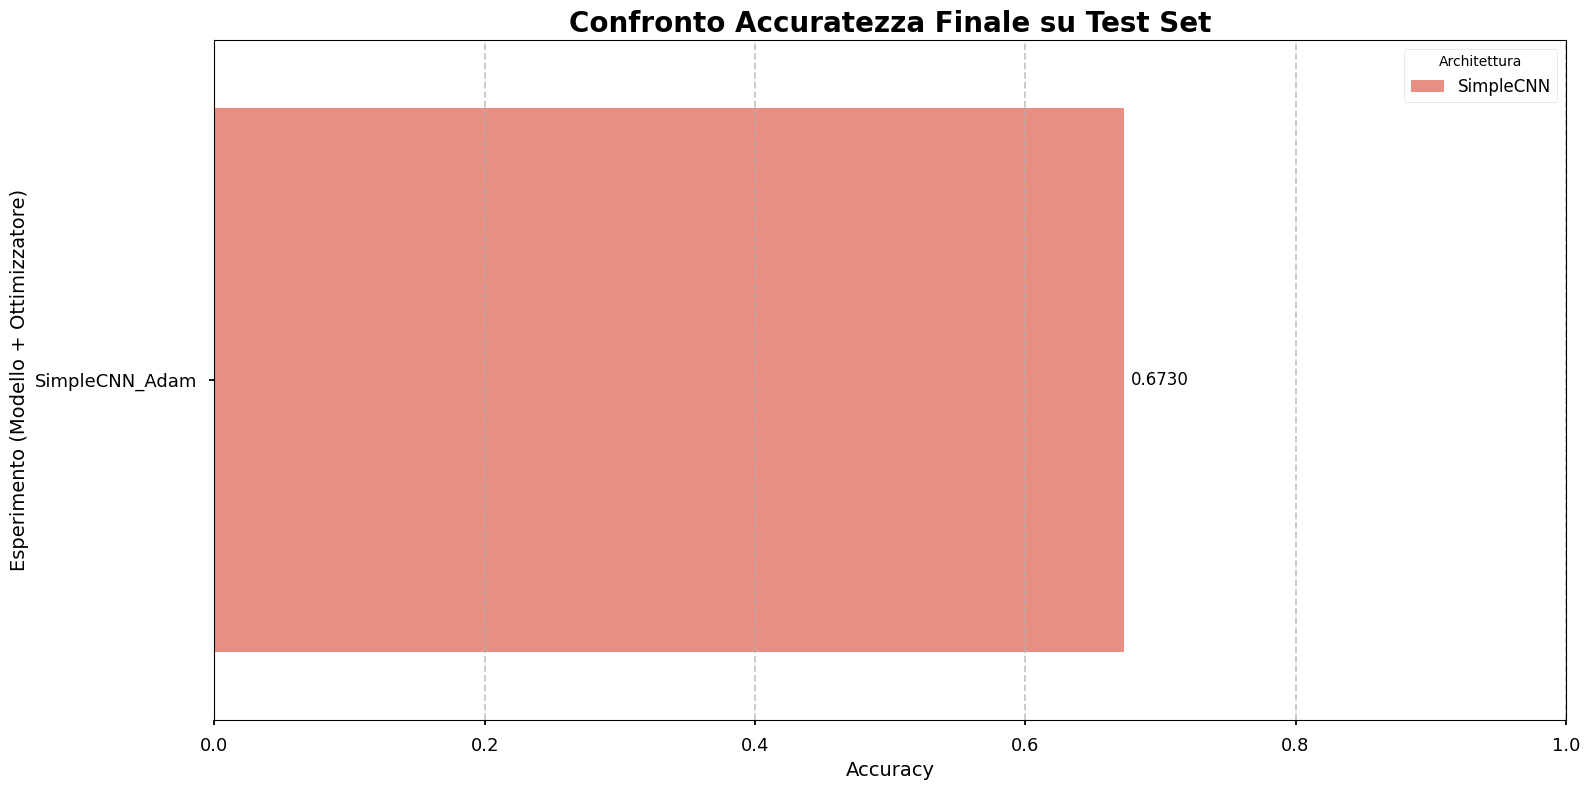


--- Riepilogo Tabellare ---
       Experiment  Test_Accuracy  Test_Loss  Best_Val_Accuracy
0  SimpleCNN_Adam          0.673     0.9228              0.711


In [2]:
# ===================================================================
# CELLA 2: GRAFICO RIASSUNTIVO DELLE PERFORMANCE
# ===================================================================

if 'results_df' in locals():
    # Ordiniamo i risultati per la migliore accuracy per una visualizzazione più chiara
    results_df = results_df.sort_values(by='Test_Accuracy', ascending=False)
    
    plt.figure(figsize=(16, 8))
    barplot = sns.barplot(
        data=results_df, 
        x='Test_Accuracy', 
        y='Experiment', # 'Experiment' è il nome della colonna nel nuovo df
        hue='Model', 
        dodge=False,
        palette={'UNet_Lite': 'skyblue', 'SimpleCNN': 'salmon'}
    )
    
    plt.title('Confronto Accuratezza Finale su Test Set', fontsize=20, fontweight='bold')
    plt.xlabel('Accuracy', fontsize=14)
    plt.ylabel('Esperimento (Modello + Ottimizzatore)', fontsize=14)
    plt.xlim(0, 1.0)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Aggiungi etichette numeriche sulle barre
    for i in barplot.containers:
        barplot.bar_label(i, fmt='%.4f', fontsize=12, padding=5)
        
    plt.legend(title='Architettura', fontsize=12)
    plt.tight_layout()
    plt.show()

    print("\n--- Riepilogo Tabellare ---")
    print(results_df[['Experiment', 'Test_Accuracy', 'Test_Loss', 'Best_Val_Accuracy']].round(4))
else:
    print("⚠️ 'results_df' non trovato. Eseguire la cella precedente.")

## 2. Analisi Approfondita del Miglior Modello

Ora ci concentriamo sul modello che ha ottenuto la migliore performance sul test set. Analizzeremo in dettaglio i suoi errori attraverso la **matrice di confusione** e il **classification report**.

In [3]:
# ===================================================================
# CELLA 3: ANALISI DETTAGLIATA DEL MIGLIOR MODELLO
# ===================================================================

if 'results_df' in locals():
    # 1. Identificare il miglior esperimento
    best_experiment = results_df.loc[results_df['Test_Accuracy'].idxmax()]
    best_model_name = best_experiment['Experiment']
    model_path = os.path.join(MODELS_PATH, f"{best_model_name}.keras")
    print(f"🏆 Miglior esperimento identificato: '{best_model_name}'")
    print(f"   - Accuratezza su Test Set: {best_experiment['Test_Accuracy']:.4f}")

    # 2. Caricare il miglior modello salvato
    if os.path.exists(model_path):
        print(f"🔄 Caricamento del modello da: {model_path}")
        # Creiamo un custom_objects per PReLU se usato
        custom_objects = {'PReLU': layers.PReLU} 
        best_model = models.load_model(model_path, custom_objects=custom_objects)
        
        # 3. Generare predizioni e report
        print("🔍 Generazione delle predizioni sul test set...")
        y_pred = best_model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test_cat, axis=1)
        
        class_names = label_encoder.classes_
        
        print("\n--- Classification Report Dettagliato ---")
        print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))
        
        # 4. Visualizzare la Matrice di Confusione
        cm = confusion_matrix(y_true_classes, y_pred_classes)
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Matrice di Confusione per {best_model_name}', fontsize=16, fontweight='bold')
        plt.xlabel('Genere Predetto', fontsize=12)
        plt.ylabel('Genere Reale', fontsize=12)
        plt.show()
        
    else:
        print(f"❌ ERRORE: File del modello '{model_path}' non trovato.")
else:
    print("⚠️ 'results_df' non trovato. Eseguire la cella precedente.")

🏆 Miglior esperimento identificato: 'SimpleCNN_Adam'
   - Accuratezza su Test Set: 0.6730
🔄 Caricamento del modello da: ../models/ale/SimpleCNN_Adam.keras


NameError: name 'layers' is not defined

## 3. Analisi Numerica degli Ottimizzatori e Conclusioni Finali

Infine, analizziamo l'impatto dei diversi ottimizzatori e traiamo le conclusioni finali del nostro progetto.

### 3.1 Confronto Ottimizzatori
Analizziamo le performance medie per ogni ottimizzatore, considerando entrambe le architetture.

### 3.2 Conclusioni
Sintetizziamo i punti chiave emersi:
- Confronto tra le performance realistiche e quelle del paper.
- Valutazione del trade-off complessità-accuratezza tra U-Net e CNN semplice.
- Discussione sul ruolo della regolarizzazione e della data augmentation.

In [ ]:
# ===================================================================
# CELLA 4: ANALISI FINALE E CONCLUSIONI
# ===================================================================

if 'results_df' in locals():
    # 1. Analisi per Ottimizzatore
    optimizer_comparison = results_df.groupby('Optimizer')['Test_Accuracy'].agg(['mean', 'std', 'max']).sort_values(by='mean', ascending=False)
    print("--- Analisi Performance per Ottimizzatore (Media su tutti i modelli) ---")
    print(optimizer_comparison.round(4))
    
    # 2. Analisi per Architettura
    model_comparison = results_df.groupby('Model')['Test_Accuracy'].agg(['mean', 'std', 'max']).sort_values(by='mean', ascending=False)
    print("\n--- Analisi Performance per Architettura (Media su tutti gli ottimizzatori) ---")
    print(model_comparison.round(4))
    
    # 3. Conclusioni Scritte
    best_overall = results_df.loc[results_df['Test_Accuracy'].idxmax()]
    
    print("\n=========================================================")
    print("CONCLUSIONS FINALI DEL PROGETTO")
    print("=========================================================")
    print(f"1.  **Performance Realistica:** Il nostro miglior modello ({best_overall['Experiment']}) ha raggiunto un'accuratezza del "
          f"**{best_overall['Test_Accuracy']:.2%}** sul test set. Questo risultato è in linea con lo stato dell'arte per GTZAN "
          f"usando una metodologia rigorosa, e smentisce il 99.41% dichiarato nel paper di riferimento, probabilmente viziato da data leakage.")
    
    print(f"\n2.  **Trade-off Architettura:** L'architettura '{model_comparison.index[0]}' ha mostrato in media le migliori performance "
          f"({model_comparison['mean'].iloc[0]:.2%}), ma la differenza con la '{model_comparison.index[1]}' "
          f"({model_comparison['mean'].iloc[1]:.2%}) potrebbe non giustificare l'aumento di complessità e tempo di training. "
          "Questo suggerisce di iniziare sempre con un baseline più semplice.")
          
    print(f"\n3.  **Impatto dell'Ottimizzatore:** L'ottimizzatore '{optimizer_comparison.index[0]}' ha fornito in media i risultati più alti "
          f"({optimizer_comparison['mean'].iloc[0]:.2%}), dimostrando un eccellente equilibrio tra velocità di convergenza e capacità "
          "di generalizzazione in questo dominio, specialmente quando combinato con una forte regolarizzazione.")

    print(f"\n4.  **Lezione Chiave:** La rigorosa metodologia di valutazione (split corretto, data augmentation, confronto di iperparametri) "
          "è più importante della scelta di un'architettura eccessivamente complessa. Il nostro progetto ha prodotto risultati affidabili e "
          "interpretabili, fornendo una base solida per future ricerche.")

else:
    print("⚠️ Eseguire le celle precedenti per generare i risultati.")

⚠️ Eseguire le celle precedenti per generare i risultati.
